# Задание

1. [Датасет](https://archive.ics.uci.edu/dataset/856/higher+education+students+performance+evaluation) с данными про оценки студентов инженерного и педагогического факультетов (для данного датасета нужно ввести метрику: студент успешный/неуспешный на основании грейда)
2. Отобрать случайным образом sqrt(n) признаков
3. Реализовать без использования сторонних библиотек построение дерева решений (дерево не бинарное, numpy и pandas использовать можно, использовать список списков для реализации дерева - нельзя) для решения задачи бинарной классификации
4. Провести оценку реализованного алгоритма с использованием Accuracy, precision и recall
5. Построить кривые AUC-ROC и AUC-PR (в пунктах 4 и 5 использовать библиотеки нельзя)

# Решение

In [21]:
import pandas as pd
import numpy as np

In [22]:
file_path = './archive/data.csv'
data = pd.read_csv(file_path)

## Обработка данных
Отсутствующих данных в датасете нет, поэтому необходимости в их обработке нет.
Переименуем колонки для удобства работы с ними.

In [23]:
new_column_names = [
    "Student ID", "Student Age", "Sex", "Graduated high-school type", "Scholarship type", "Additional work", "Regular artistic or sports activity", "Do you have a partner", "Total salary if available", "Transportation to the university", "Accommodation type", "Mother's education", "Father's education", "Number of sisters/brothers", "Parental status", "Mother's occupation", "Father's occupation", "Weekly study hours", "Reading frequency (non-scientific books/journals)", "Reading frequency (scientific books/journals)", "Attendance to the seminars/conferences related to the department", "Impact of your projects/activities on your success", "Attendance to classes", "Preparation to midterm exams 1", "Preparation to midterm exams 2", "Taking notes in classes", "Listening in classes", "Discussion improves my interest and success in the course", "Flip-classroom", "Cumulative grade point average in the last semester", "Expected Cumulative grade point average in the graduation", "Course ID", "OUTPUT Grade"    
]

data.columns = new_column_names
data

,Student ID,Student Age,Sex,Graduated high-school type,Scholarship type,Additional work,Regular artistic or sports activity,Do you have a partner,Total salary if available,Transportation to the university,...,Preparation to midterm exams 1,Preparation to midterm exams 2,Taking notes in classes,Listening in classes,Discussion improves my interest and success in the course,Flip-classroom,Cumulative grade point average in the last semester,Expected Cumulative grade point average in the graduation,Course ID,OUTPUT Grade
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,STUDENT141,2,1,2,3,1,1,2,1,1,...,1,1,2,1,2,1,3,3,9,5
141,STUDENT142,1,1,2,4,2,2,2,1,4,...,1,1,3,2,2,1,5,3,9,5
142,STUDENT143,1,1,1,4,2,2,2,1,1,...,1,1,3,3,2,1,4,3,9,1
143,STUDENT144,2,1,2,4,1,1,1,5,2,...,2,1,2,1,2,1,5,3,9,4


## Определение бинарной метки успешности студента

Для задачи бинарной классификации необходимо преобразовать многоклассовую метку OUTPUT Grade в бинарную: успешный/неуспешный студент.

In [24]:
# Удаление ненужных колонок и добавление бинарной метки успеха
def preprocess_data(data, success_threshold):
    output_label, id_label = "OUTPUT Grade", "Student ID"
    success_label = "Success"
    
    # Бинаризация метки
    output_column = data[output_label]
    success_column = output_column.apply(lambda x: 1 if x >= success_threshold else 0)
    data[success_label] = success_column
    
    # Удаление ненужных колонок
    data = data.drop(columns=[output_label, id_label])
    
    return data, success_label

# Случайным образом отберем sqrt(n) признаков
def select_features(data, success_label, random_seed=1):
    sqrt_n = int(np.sqrt(len(data.columns) - 1))  # -1, так как 'Success' добавлена
    np.random.seed(random_seed)
    random_columns = np.random.choice(data.columns.drop(success_label), sqrt_n, replace=False)
    selected_columns = list(random_columns) + [success_label]
    data = data[selected_columns]
    print(f"Selected columns: {sqrt_n} features\n{random_columns}")
    return data

# Предобработка данных с порогом t
def get_binarized_data(data, t):
    data_t = data.copy()
    data_t['Success'] = data_t['Success']  # Уже бинаризировано
    return data_t

## Дерево решений

Без использования сторонних библиотек построение дерева решений для решения задачи бинарной классификации.

Реализуем дерево решений по алгоритму C4.5, который использует отношение прироста информации (Information Gain Ratio) для выбора оптимальных признаков.

In [25]:
class DecisionTreeNode:
    def __init__(self, attribute=None, branches=None, is_leaf=False, prediction=None, class_counts=None):
        self.attribute = attribute          # Атрибут для разбиения
        self.branches = branches or {}      # Дочерние узлы
        self.is_leaf = is_leaf              # Является ли узел листом
        self.prediction = prediction        # Предсказание класса (для листа)
        self.class_counts = class_counts    # Количество классов (для вероятностей)

    def predict_instance(self, instance):
        if self.is_leaf:
            return self.prediction
        attribute_value = instance.get(self.attribute)
        if attribute_value in self.branches:
            return self.branches[attribute_value].predict_instance(instance)
        else:
            # Если значение атрибута не встречалось при обучении, возвращаем наиболее частый класс
            return self.prediction

    def predict_proba_instance(self, instance):
        if self.is_leaf:
            total = sum(self.class_counts.values())
            proba = self.class_counts.get(1, 0) / (total + 1e-9)
            return proba
        attribute_value = instance.get(self.attribute)
        if attribute_value in self.branches:
            return self.branches[attribute_value].predict_proba_instance(instance)
        else:
            # Если значение атрибута не встречалось при обучении, возвращаем вероятности наиболее частого класса
            total = sum(self.class_counts.values())
            proba = self.class_counts.get(1, 0) / (total + 1e-9)
            return proba

class DecisionTree:
    def __init__(self):
        self.root = None

    def entropy(self, y):
        class_counts = y.value_counts()
        probabilities = class_counts / len(y)
        return -sum(probabilities * np.log2(probabilities + 1e-9))  # Добавляем 1e-9 для избежания log(0)

    def information_gain_ratio(self, X, y, attribute):
        # Энтропия до разбиения
        entropy_before = self.entropy(y)

        # Группировка по значению атрибута
        values, counts = np.unique(X[attribute], return_counts=True)
        weighted_entropy = 0
        split_info = 0
        for v, count in zip(values, counts):
            subset_y = y[X[attribute] == v]
            subset_entropy = self.entropy(subset_y)
            weighted_entropy += (count / len(y)) * subset_entropy
            split_info -= (count / len(y)) * np.log2((count / len(y)) + 1e-9)

        info_gain = entropy_before - weighted_entropy
        gain_ratio = info_gain / (split_info + 1e-9)  # Добавляем 1e-9 для избежания деления на ноль
        return gain_ratio

    def build_tree_recursive(self, X, y, attributes, default_class=None):
        if len(y) == 0:
            return DecisionTreeNode(is_leaf=True, prediction=default_class)
        elif len(y.unique()) == 1:
            return DecisionTreeNode(is_leaf=True, prediction=y.iloc[0], class_counts=y.value_counts().to_dict())
        elif len(attributes) == 0:
            majority_class = y.mode()[0]
            class_counts = y.value_counts().to_dict()
            return DecisionTreeNode(is_leaf=True, prediction=majority_class, class_counts=class_counts)
        else:
            default_class = y.mode()[0]
            # Выбор атрибута с максимальным Gain Ratio
            gain_ratios = {attr: self.information_gain_ratio(X, y, attr) for attr in attributes}
            best_attr = max(gain_ratios, key=gain_ratios.get)

            # Создание узла
            class_counts = y.value_counts().to_dict()
            tree = DecisionTreeNode(attribute=best_attr, prediction=default_class, class_counts=class_counts)

            # Разбиение по значениям лучшего атрибута
            for attr_val in np.unique(X[best_attr]):
                subset_X = X[X[best_attr] == attr_val].drop(columns=[best_attr])
                subset_y = y[X[best_attr] == attr_val]
                subtree = self.build_tree_recursive(
                    subset_X,
                    subset_y,
                    [attr for attr in attributes if attr != best_attr],
                    default_class=default_class
                )
                tree.branches[attr_val] = subtree
            return tree

    def build_tree(self, X, y):
        attributes = list(X.columns)
        self.root = self.build_tree_recursive(X, y, attributes)
        print("Дерево решений построено.")

    def predict_instance(self, instance):
        return self.root.predict_instance(instance)

    def predict_proba_instance(self, instance):
        return self.root.predict_proba_instance(instance)

    def predict(self, X):
        return X.apply(self.predict_instance, axis=1).values

    def predict_proba(self, X):
        return X.apply(self.predict_proba_instance, axis=1).values

    def compute_metrics(self, y_true, y_pred):
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))

        confusion_matrix = np.array([[TN, FP], [FN, TP]])
        accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-9)
        precision = TP / (TP + FP + 1e-9)
        recall = TP / (TP + FN + 1e-9)

        return confusion_matrix, accuracy, precision, recall

    def calculate_auc(self, y_true, y_scores, curve_type='ROC'):
        # Сортируем по убыванию вероятностей
        desc_score_indices = np.argsort(-y_scores)
        y_true = y_true[desc_score_indices]
        y_scores = y_scores[desc_score_indices]

        # Уникальные значения
        distinct_value_indices = np.where(np.diff(y_scores))[0]
        threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

        tps = np.cumsum(y_true)[threshold_idxs]
        fps = 1 + threshold_idxs - tps

        tps = np.r_[0, tps]
        fps = np.r_[0, fps]

        if curve_type == 'ROC':
            fpr = fps / fps[-1] if fps[-1] != 0 else fps
            tpr = tps / tps[-1] if tps[-1] != 0 else tps
            auc = np.trapezoid(tpr, fpr)
            return fpr, tpr, auc
        elif curve_type == 'PR':
            precision = tps / (tps + fps + 1e-9)
            recall = tps / tps[-1] if tps[-1] != 0 else tps
            auc = np.trapezoid(precision, recall)
            return recall, precision, auc
        else:
            raise ValueError("curve_type должен быть 'ROC' или 'PR'")

    def calculate_auc_metrics(self, y_true, y_scores):
        # Расчет AUC-ROC
        fpr, tpr, auc_roc = self.calculate_auc(y_true, y_scores, curve_type='ROC')
        # Расчет AUC-PR
        recall, precision, auc_pr = self.calculate_auc(y_true, y_scores, curve_type='PR')
        return (fpr, tpr, auc_roc), (recall, precision, auc_pr)

    def __str__(self):
        lines = []
        self._str_recursive(self.root, lines, "")
        return "\n".join(lines)

    def _str_recursive(self, node, lines, prefix):
        if node.is_leaf:
            lines.append(f"{prefix}Leaf: {node.prediction} (Counts: {node.class_counts})")
        else:
            lines.append(f"{prefix}Attribute: {node.attribute}")
            for i, (value, subtree) in enumerate(node.branches.items()):
                connector = "├─ " if i < len(node.branches) - 1 else "└─ "
                lines.append(f"{prefix} {connector}{value} -> ")
                new_prefix = prefix + ("│  " if i < len(node.branches) - 1 else "   ")
                self._str_recursive(subtree, lines, new_prefix)


## Разделение Данных на Обучающую и Тестовую Выборки

In [26]:
def train_test_split_custom(X, y, test_size=0.2, random_state=1):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_size = int(len(X) * test_size)

    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    return X.iloc[train_indices], X.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]


In [27]:
# Определение порогов
thresholds = range(1, 7)  # От 1 до 6 включительно

# Случайным образом отберем sqrt(n) признаков один раз для всех порогов
preprocessed_data, success_label = preprocess_data(data, success_threshold=2)  # Временный порог
selected_data = select_features(preprocessed_data, success_label, random_seed=1)

# Сохраним выбранные признаки
selected_features = selected_data.columns.drop(success_label)
print(f"Выбранные признаки для всех порогов: {selected_features.tolist()}")

Selected columns: 5 features
['Flip-classroom' 'Scholarship type'
 'Attendance to the seminars/conferences related to the department'
 'Preparation to midterm exams 2' 'Preparation to midterm exams 1']
Выбранные признаки для всех порогов: ['Flip-classroom', 'Scholarship type', 'Attendance to the seminars/conferences related to the department', 'Preparation to midterm exams 2', 'Preparation to midterm exams 1']


In [28]:
# Хранение результатов
results = {}

for t in thresholds:
    print(f"\nОбработка порога: {t}")
    # Бинаризация меток с текущим порогом
    binarized_data, _ = preprocess_data(data, success_threshold=t)
    binarized_data = binarized_data[selected_features.tolist() + [success_label]]
    
    # Разделение данных
    X = binarized_data.drop(columns=[success_label])
    y = binarized_data[success_label]
    X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_size=0.2, random_state=1)
    
    print(f"Размер обучающей выборки: {X_train.shape[0]}")
    print(f"Размер тестовой выборки: {X_test.shape[0]}")
    
    # Обучение дерева
    tree = DecisionTree()
    tree.build_tree(X_train, y_train)
    
    # Предсказание
    y_pred = tree.predict(X_test)
    y_proba = tree.predict_proba(X_test)
    
    # Вычисление метрик
    confusion_matrix, accuracy, precision, recall = tree.compute_metrics(y_test.values, y_pred)
    
    # Вычисление AUC-ROC и AUC-PR
    auc_roc_metrics, auc_pr_metrics = tree.calculate_auc_metrics(y_test.values, y_proba)
    fpr, tpr, auc_roc = auc_roc_metrics
    recall_vals, precision_vals, auc_pr = auc_pr_metrics
    
    # Сохранение результатов
    results[t] = {
        'confusion_matrix': confusion_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
        'auc_roc': auc_roc,
        'recall_vals': recall_vals,
        'precision_vals': precision_vals,
        'auc_pr': auc_pr,
        'tree': tree
    }
    
    # Вывод метрик
    print(f"Confusion Matrix:\n{confusion_matrix}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    
    # print(f"Дерево для порога {t}:\n{tree}")



Обработка порога: 1
Размер обучающей выборки: 116
Размер тестовой выборки: 29
Дерево решений построено.
Confusion Matrix:
[[ 1  0]
 [ 2 26]]
Accuracy: 0.9310
Precision: 1.0000
Recall: 0.9286
AUC-ROC: 0.9643
AUC-PR: 0.9273

Обработка порога: 2
Размер обучающей выборки: 116
Размер тестовой выборки: 29
Дерево решений построено.
Confusion Matrix:
[[ 5  7]
 [ 2 15]]
Accuracy: 0.6897
Precision: 0.6818
Recall: 0.8824
AUC-ROC: 0.5270
AUC-PR: 0.5812

Обработка порога: 3
Размер обучающей выборки: 116
Размер тестовой выборки: 29
Дерево решений построено.
Confusion Matrix:
[[ 8  7]
 [ 3 11]]
Accuracy: 0.6552
Precision: 0.6111
Recall: 0.7857
AUC-ROC: 0.5548
AUC-PR: 0.5472

Обработка порога: 4
Размер обучающей выборки: 116
Размер тестовой выборки: 29
Дерево решений построено.
Confusion Matrix:
[[15  3]
 [ 8  3]]
Accuracy: 0.6207
Precision: 0.5000
Recall: 0.2727
AUC-ROC: 0.5303
AUC-PR: 0.4097

Обработка порога: 5
Размер обучающей выборки: 116
Размер тестовой выборки: 29
Дерево решений построено.
Con

## Построение Кривых AUC-ROC и AUC-PR

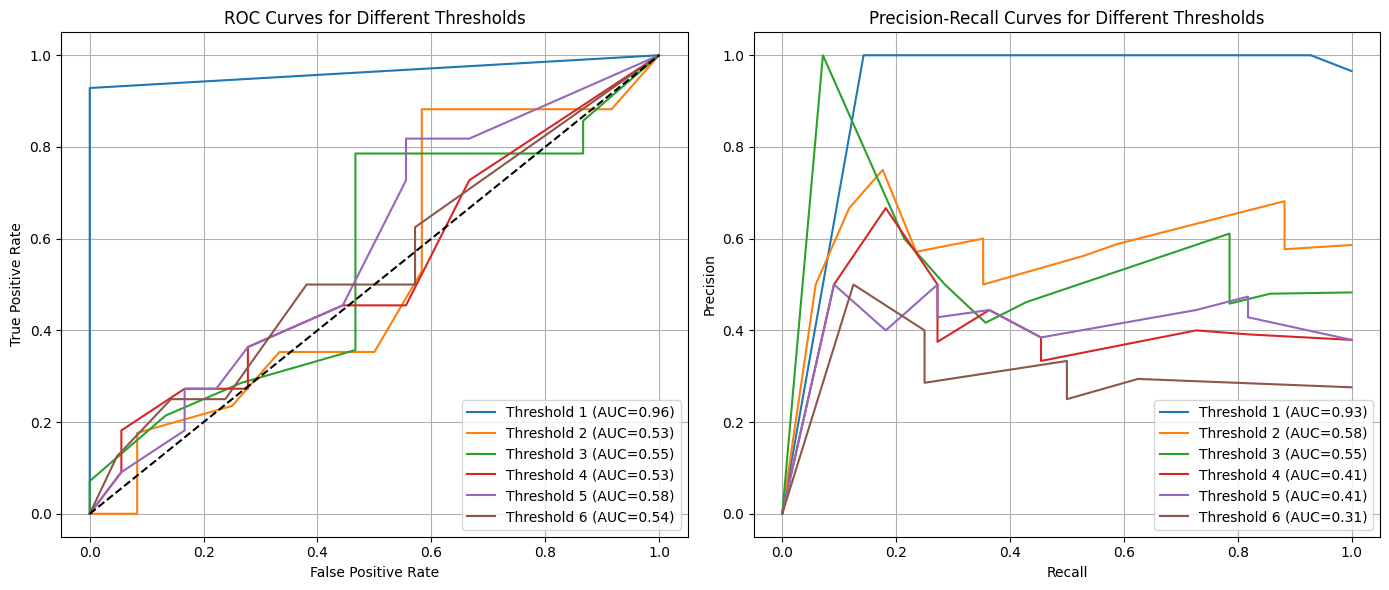

Threshold 1:
  FPR: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
  TPR: [0.         0.14285714 0.42857143 0.57142857 0.60714286 0.67857143
 0.82142857 0.92857143 1.        ]
  Recall: [0.         0.14285714 0.42857143 0.57142857 0.60714286 0.67857143
 0.82142857 0.92857143 1.        ]
  Precision: [0.         1.         1.         1.         1.         1.
 1.         1.         0.96551724]
Threshold 2:
  FPR: [0.         0.08333333 0.08333333 0.08333333 0.08333333 0.25
 0.33333333 0.5        0.58333333 0.58333333 0.58333333 0.66666667
 0.91666667 1.        ]
  TPR: [0.         0.         0.05882353 0.11764706 0.17647059 0.23529412
 0.35294118 0.35294118 0.52941176 0.58823529 0.88235294 0.88235294
 0.88235294 1.        ]
  Recall: [0.         0.         0.05882353 0.11764706 0.17647059 0.23529412
 0.35294118 0.35294118 0.52941176 0.58823529 0.88235294 0.88235294
 0.88235294 1.        ]
  Precision: [0.         0.         0.5        0.66666667 0.75       0.57142857
 0.6        0.5        0.5625     0.58

In [29]:
import matplotlib.pyplot as plt

# Построение кривых AUC-ROC
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for t in thresholds:
    plt.plot(results[t]['fpr'], results[t]['tpr'], label=f'Threshold {t} (AUC={results[t]["auc_roc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Диагональ
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Thresholds")
plt.legend()
plt.grid(True)


# Построение кривых AUC-PR
plt.subplot(1, 2, 2)
for t in thresholds:
    plt.plot(results[t]['recall_vals'], results[t]['precision_vals'], label=f'Threshold {t} (AUC={results[t]["auc_pr"]:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Different Thresholds")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

for t in thresholds:
    fpr = results[t]['fpr']
    tpr = results[t]['tpr']
    recall_vals = results[t]['recall_vals']
    precision_vals = results[t]['precision_vals']
    
    print(f"Threshold {t}:")
    print(f"  FPR: {fpr}")
    print(f"  TPR: {tpr}")
    print(f"  Recall: {recall_vals}")
    print(f"  Precision: {precision_vals}")

## Таблица с метриками для всех порогов

In [30]:
metrics_table = pd.DataFrame(columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'AUC-ROC', 'AUC-PR'])

for t in thresholds:
    row = pd.DataFrame([{
        'Threshold': t,
        'Accuracy': results[t]['accuracy'],
        'Precision': results[t]['precision'],
        'Recall': results[t]['recall'],
        'AUC-ROC': results[t]['auc_roc'],
        'AUC-PR': results[t]['auc_pr']
    }])
    metrics_table = pd.concat([metrics_table, row], ignore_index=True)

print("\nМетрики для различных порогов:")
print(metrics_table)


Метрики для различных порогов:
  Threshold  Accuracy  Precision    Recall   AUC-ROC    AUC-PR
0         1  0.931034   1.000000  0.928571  0.964286  0.927340
1         2  0.689655   0.681818  0.882353  0.526961  0.581247
2         3  0.655172   0.611111  0.785714  0.554762  0.547213
3         4  0.620690   0.500000  0.272727  0.530303  0.409744
4         5  0.620690   0.500000  0.272727  0.578283  0.410143
5         6  0.689655   0.400000  0.250000  0.541667  0.305760


C:\Users\Gleb\AppData\Local\Temp\ipykernel_4788\1553533185.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_table = pd.concat([metrics_table, row], ignore_index=True)
